In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import numpy as np
import linecache #fast access to a specific file line
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from einops import rearrange, repeat
import torch.nn.functional as F
import time
from pathlib import Path

In [4]:
from torchinfo import summary

In [5]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.11.0
11.1
True


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
ALPHABET = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
            "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

ALPHABET = {ALPHABET[i]:i for i in range(len(ALPHABET))}

ALPHABET['-']= 20
ALPHABET['Z']= 21

In [14]:
print(ALPHABET)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19, '-': 20, 'Z': 21}


In [15]:
class MyDataset(Dataset):
    def __init__(self, data_dir, cont_size=6):
        self.col_size = 60 #number of column per file (Fasta standard)
        self.data_dir = data_dir #directory of the dataset
        self.cont_size = cont_size
        self.len = 0  #number of families of sequences (1 per file)
        self.paths = {} #path of each families in the folder
        self.seq_lens = {} #length of each member of the family
        self.seq_nums = {} #number of member of the family
        
        
        dir_path = data_dir
        count = 0
        
        # Iterate directory
        for path in os.listdir(dir_path):
            # check if current path is a file
            temp_path = os.path.join(dir_path, path)
            if os.path.isfile(temp_path):
                n = 0 #number of sequences
                p = 0 # used to calculate the length of the sequences
                r = 0 # also used this way

                l = 0 # length of the seq l = p * self.col_size + r 

                cpt = 0 # to detect inconsistencies
                
                with open(temp_path, newline='') as f:
                    first_prot = True
                    newf = True
                    
                    #parsing the file
                    line = f.readline()
                    while line:
                        cpt += 1
                        if line[0] == '>': #header line
                            n += 1
                            if newf and not first_prot:
                                newf = False
                            first_prot = False
                                
                        else:# sequence line
                            line = line.strip() #removing "\n"
                            if newf and len(line) == self.col_size:
                                p += 1

                            if newf and len(line) != self.col_size:
                                r = len(line)
                                #newf = False


                            assert len(line) == self.col_size or len(line) == r
                        line = f.readline()

                l = p*self.col_size + r
                
                #sanity check
                #if the file line count is coherent with the number of sequences and their line count
                try: #if r != 0
                    assert (p+2) * n == cpt
                except: #if r == 0
                    assert (p+1) * n == cpt
                    assert r == 0
                    
                
                if l > 2*self.cont_size and n>1: #if this is false, we can't compute the context window of find pairs
                    self.paths[count] = path
                    self.seq_lens[count] = l
                    self.seq_nums[count] = n
                    count += 1
            
        self.len = count
    
    def __len__(self):
        return self.len
     
    def sample(self, high, low=0, s=1):
        sample = np.random.choice(high-low, s, replace=False)
        return sample + low
    
    def __getitem__(self, idx, sample_size='auto'): 
        #for each sample:
        #sample i, j st i != j the two sequences to compare
        #sample k the sequence position of the prediction
        #compute the file positions of the 25 + 1 AA
        
        X = []
        y = []
        
        PIDs = []
        local_PIDs = []
        
        freqs = []

        
        
        data_path = os.path.join(self.data_dir, self.paths[idx])
        try:
            n = self.seq_nums[idx]
            l = self.seq_lens[idx]
        except:
            print(idx)
            pass
        
        if type(sample_size) != int:
            coef = round((n**2 * l)/1400000) 
            sample_size = max(1,coef)
        
        p = l // self.col_size
        r = l % self.col_size # l = p * q + r
        sequence_line_count = p+2 if r else p+1


        for _ in range(sample_size):
            i,j = self.sample(n,s=2)
            
            start_i = 2 + (sequence_line_count)*i #start line of protein i
            start_j = 2 + (sequence_line_count)*j #start line of protein j
            
            
            PID_ij = 0
            l_i = 0
            l_j = 0
            
            freq_i = torch.zeros(20)
            freq_j = torch.zeros(20)
            
            aa_cpt = 0
            possible_k = []
            for offset in range(sequence_line_count-1):
                line_i = linecache.getline(data_path, (start_i + offset))
                line_i = line_i.strip()
                
                line_j = linecache.getline(data_path, (start_j + offset))
                line_j = line_j.strip()
                
                PID_ij += sum(1 for AA1,AA2 in zip(line_i, line_j) if AA1 == AA2 and AA1 != '-')
                l_i += sum(1 for AA in line_i if AA != '-')
                l_j += sum(1 for AA in line_j if AA != '-')
                
                for k in range(len(line_i)):
                    if (ALPHABET.get(line_i[k],21) < 20) and (ALPHABET.get(line_j[k],21) < 20):
                        if aa_cpt >= self.cont_size and (aa_cpt+self.cont_size) < l:
                            possible_k.append(aa_cpt)
                    aa_cpt += 1
                    
                    aa_i = ALPHABET.get(line_i[k],21)
                    aa_j = ALPHABET.get(line_j[k],21)
                    
                    if aa_i < 20: freq_i[aa_i] += 1
                    if aa_j < 20: freq_j[aa_j] += 1
            
            freq_i = F.normalize(freq_i,dim=0,p=1)
            freq_j = F.normalize(freq_j,dim=0,p=1)
            
            freqs.append(torch.stack([freq_i,freq_j]))
            
            
            try:
                PID_ij = PID_ij/min(l_i,l_j)
            except:
                print("error")
                PID_ij = 0
            
            try:
                k = np.random.choice(possible_k)
            except:
                continue
            offset = (k-self.cont_size)//self.col_size #line in which the sampled AA is

            start_w = (k-self.cont_size)%self.col_size #idx of the window start
            end_w = (k+self.cont_size+1)%self.col_size
            
            

            #getting the windows
            if start_w < end_w: #Case on one line
                line_i = linecache.getline(data_path, (start_i + offset))
                line_i = line_i.strip()

                line_j = linecache.getline(data_path, (start_j + offset))
                line_j = line_j.strip()

                window_i = line_i[start_w:end_w]
                window_j = line_j[start_w:end_w]


            else: #Case on two lines
                #first line
                line_i = linecache.getline(data_path, (start_i + offset))
                line_i = line_i.strip()

                line_j = linecache.getline(data_path, (start_j + offset))
                line_j = line_j.strip()

                window_temp_i = line_i[start_w:]
                window_temp_j = line_j[start_w:]

                #second line
                line_i = linecache.getline(data_path, (start_i + offset + 1))
                line_i = line_i.strip()

                line_j = linecache.getline(data_path, (start_j + offset + 1))
                line_j = line_j.strip()

                window_i = line_i[:end_w]
                window_j = line_j[:end_w]

                #merging
                window_i = window_temp_i + window_i
                window_j = window_temp_j + window_j

            y_j = ALPHABET.get(window_j[self.cont_size], 21) # 'Z' is the default value for rare AA
            X_i = [ALPHABET.get(i, 21) for i in (window_i+window_j[:self.cont_size]+window_j[self.cont_size+1:])]       
            
            X.append(X_i)
            y.append(y_j)
            PIDs.append(PID_ij)
            local_PID_ij = sum(1 for AA1,AA2 in zip(window_i, window_j[:self.cont_size]) if AA1 == AA2 and AA1 != '-') \
                         + sum(1 for AA1,AA2 in zip(reversed(window_i), reversed(window_j[self.cont_size+1:])) if AA1 == AA2 and AA1 != '-')
            
            local_l_i = sum(1 for AA in window_i[:self.cont_size] if AA != '-') + sum(1 for AA in window_i[self.cont_size+1:] if AA != '-')
            local_l_j = sum(1 for AA in window_j[:self.cont_size] if AA != '-') + sum(1 for AA in window_j[self.cont_size+1:] if AA != '-')
            try:
                tmp = local_PID_ij/min(local_l_i,local_l_j)
            except:
                tmp = 0
                
            local_PIDs.append(tmp)
            
            assert y_j < 20
            assert X_i[self.cont_size] < 20
            
        linecache.clearcache()
        X = torch.tensor(X)
        try:
            X = F.one_hot(X,22)[:,:,0:-1]
        except RuntimeError:
            pass
        return X.float(),torch.tensor(y).long(),torch.tensor(PIDs),torch.tensor(local_PIDs), torch.stack(freqs)

    

In [16]:
train_dataset = MyDataset(r"data/train_data",cont_size = 6)
test_dataset = MyDataset(r"data/test_data",cont_size = 6)
val_dataset = MyDataset(r"data/val_data",cont_size = 6)
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

13202
2835
2817


In [17]:
def my_collate(batch):
    data = torch.cat([item[0] for item in batch],dim=0)
    target = torch.cat([item[1] for item in batch],dim=0)
    #target = torch.LongTensor(target)
    PID = torch.cat([item[2] for item in batch],dim=0)
    lPID = torch.cat([item[3] for item in batch],dim=0)
    freqs = torch.cat([item[4] for item in batch],dim=0)
    
    return data, target, PID, lPID, freqs

In [18]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=my_collate,num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True,collate_fn=my_collate,num_workers=4)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,collate_fn=my_collate,num_workers=4)

# ADD THESE METADATA IN THE NETWORK
# ADD FREQ AS A NN.PARAMETER

In [20]:
class AttBlock(nn.Module):
    def __init__(self,in_features,out_features=None,num_heads=8,head_dims=24):
        super().__init__()
        out_features = out_features or in_features
        
        self.Q_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.K_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        self.V_w = nn.Linear(in_features,num_heads*head_dims,bias=False)
        
        self.att = nn.MultiheadAttention(num_heads*head_dims,num_heads=num_heads,batch_first=True)
        self.lin = nn.Linear(num_heads*head_dims,out_features)
        
    def forward(self,x):
        Q = self.Q_w(x)
        K = self.K_w(x)
        V = self.V_w(x)
        out,_ = self.att(Q,K,V,need_weights=False)
        out = self.lin(out)
        
        return out

In [21]:
class FeedFoward(nn.Module):
    def __init__(self,in_features,out_features=None,wide_factor=4):
        super().__init__()
        out_features = out_features or in_features
        hidden_dim = wide_factor * in_features
        
        self.lin1 = nn.Linear(in_features,hidden_dim)
        self.act1 = nn.GELU()
        self.lin2 = nn.Linear(hidden_dim,out_features)
        self.act2 = nn.GELU()
        
    def forward(self,x):
        out = self.lin1(x)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        
        return out

In [22]:
def drop_path(x, drop_prob: float = 0.1, training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None, scale_by_keep=True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)


In [23]:
class Block(nn.Module):
    def __init__(self,in_features,num_heads=8,head_dims=24,wide_factor=4,drop=0.1):
        super().__init__()
        
        self.att_block = AttBlock(in_features,num_heads=num_heads,head_dims=head_dims)
        self.ff = FeedFoward(in_features,wide_factor=wide_factor)
        self.drop_path = DropPath(drop)
        
        self.norm1 = nn.LayerNorm(in_features)
        self.norm2 = nn.LayerNorm(in_features)
    def forward(self,x):
        out = x + self.drop_path(self.att_block(x))
        out = self.norm1(out)
        out = out + self.drop_path(self.ff(out))
        out = self.norm2(out)
        return out

In [24]:
class Classifier_Head(nn.Module):
    def __init__(self,in_features,clf_dims,out_size,seq_len):
        super().__init__()
        in_dim = seq_len*in_features
        self.in_dim = in_dim
        
        layers = []
        for out_dim in clf_dims:
            layers.append(nn.Linear(in_dim,out_dim))
            layers.append(nn.GELU())
            in_dim = out_dim

        layers.append(nn.Linear(in_dim,out_size))
        
        self.clf = nn.Sequential(*layers)
        
    def forward(self,x):
        out = x.reshape((-1,self.in_dim))
        
        out = self.clf(out)
        
        return out

In [25]:
class AttNet(nn.Module):
    def __init__(self,in_features,num_heads,head_dims,wide_factors,drops,out_size=20,seq_len=29,clf_dims=[1024,256,64],cont_size=6):
        super().__init__()
        
        blocks = []
        for n_h, h_d,w,d in zip(num_heads,head_dims,wide_factors,drops):
            blocks.append(Block(in_features,num_heads=n_h,head_dims=h_d,wide_factor=w,drop=d))
        self.feature_extractor = nn.Sequential(*blocks)
        
        self.clf = Classifier_Head(in_features,clf_dims,out_size=out_size,seq_len=seq_len)
        
        self.cont_size=cont_size
        
        sp = Path("data/freq.pth")
        with sp.open("rb") as fp:
            self.F = nn.Parameter(torch.load(fp))
        
        
    def forward(self,x,PID,pfreqs):
        
        X_idx = torch.argmax(x[:,self.cont_size],dim=1)
        Fr = F.pad(self.F[X_idx].unsqueeze(1), pad=(0, 1), mode='constant', value=0)
        pf = F.pad(pfreqs, pad=(0, 1), mode='constant', value=0)
        pid = repeat(PID, "b -> b 1 e",e=20)
        pid = F.pad(pid, pad=(0, 1), mode='constant', value=0)
        
        X_input = torch.cat([x,Fr,pf,pid],dim=1)
                
        features = self.feature_extractor(X_input)
        out = self.clf(features)
        return out

In [26]:
class State:
    def __init__(self,model,optim):
        self.model = model
        self.optim = optim
        self.epoch = 0

In [30]:
def main(train_loader,val_loader,epochs=101,fname="models/state.pth",dims=[82,32,16,8,4],model=None):
    
    #to get the best model
    best = float('inf')
    
    #getting the acceleration device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    #loading from previous checkpoint
    savepath = Path(fname)
    if savepath.is_file():
        with savepath.open("rb") as fp:
            state = torch.load(fp)
    else:
        if model is None:
            model = AttNet(21,[8,8,8],[24,24,24],[4,4,4],[0.1,0.1,0.1])
        model = model.to(device)
        optim = torch.optim.Adam(model.parameters())
        state = State(model,optim)
    
    #ADD a LR Scheduler
    
    Loss = nn.CrossEntropyLoss()
    EvalLoss = nn.MSELoss()

    List_Loss = []
    Eval_Loss = []
    for epoch in range(state.epoch, epochs):
        batch_losses = []
        state.model.train()
        for X,y, PID, lPID, pfreqs in train_loader:
    
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            lPID = lPID.to(device)
            pfreqs = pfreqs.to(device)
               
            state.optim.zero_grad()
            y_hat = state.model(X,PID,pfreqs)
            
            l = Loss(y_hat,y)
            l.backward()
            state.optim.step()
            
            
            
            batch_losses.append(l.detach().cpu())
        List_Loss.append(torch.mean(torch.stack(batch_losses)).detach().cpu())
        state.epoch = epoch + 1
        
        with torch.no_grad():
            eval_losses = [] 
            state.model.eval()
            for X,y, PID, lPID, pfreqs in val_loader:

                X = X.to(device)
                y = y.to(device)
                PID = PID.to(device)
                lPID = lPID.to(device)
                pfreqs = pfreqs.to(device)

                y_hat = state.model(X,PID,pfreqs)
                y_hat = F.softmax(y_hat,dim=1)

                y = F.one_hot(y, 20)
                eval_l = (y_hat-y)**2
                eval_losses.append(torch.sum(eval_l,dim=1).mean().detach().cpu())


            score = torch.mean(torch.stack(eval_losses)).detach().cpu()
            Eval_Loss.append(score)
        
        if score < best :
            best = score
            with savepath.open("wb") as fp:
                torch.save(state,fp)
        
        print(f"epoch n°{epoch} : train_loss = {List_Loss[-1]}, test_loss = {Eval_Loss[-1]}") 
            
    return List_Loss,Eval_Loss

In [28]:
! rm models/stateATT2.pth

rm: cannot remove 'models/stateATT2.pth': No such file or directory


In [29]:
fname = "models/stateATT2.pth" 
start = time.time()
Train,Eval = main(train_dataloader, val_dataloader,fname=fname,epochs=1)
stop = time.time()
print(stop-start)

epoch n°0 : train_loss = 2.4563002586364746, test_loss = 0.8210277557373047
120.86076521873474


In [31]:
fname = "models/stateATT2.pth" 
savepath = Path(fname)
with savepath.open("rb") as fp:
    state = torch.load(fp)

In [32]:
state.epoch

1

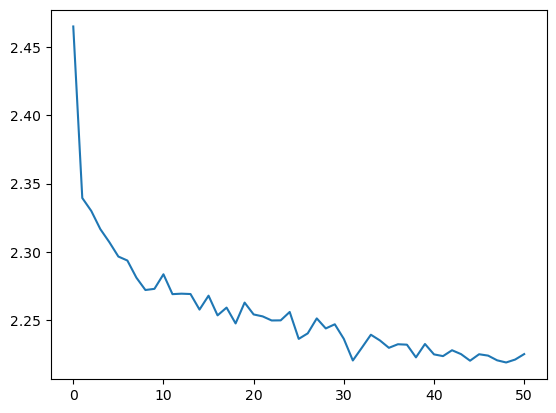

In [63]:
plt.plot(np.arange(len(Train)),Train)

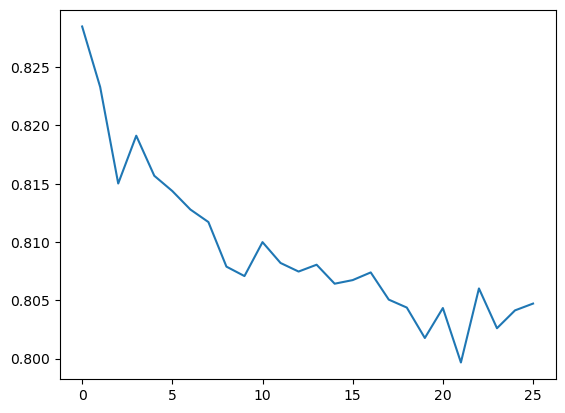

In [65]:
plt.plot(np.arange(len(Eval)),Eval)

In [42]:
def eval_model(fname,train,test,val):
    savepath = Path(fname)
    with savepath.open("rb") as fp:
        state = torch.load(fp)
        
    state.model.eval()
    with torch.no_grad():
        print('EVALUATING ON TRAIN DATA : ')
        eval_losses = []
        for X,y, PID, lPID, pfreqs in train:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            lPID = lPID.to(device)
            pfreqs = pfreqs.to(device)

            y_hat = state.model(X,PID,pfreqs)
            y_hat = F.softmax(y_hat,dim=1)

            y = F.one_hot(y, 20)
            eval_l = (y_hat-y)**2
            eval_losses.append(torch.sum(eval_l,dim=1).mean().detach().cpu())

        score_train = torch.mean(torch.stack(eval_losses)).detach().cpu().item()
        print(f"{score_train = }\n")

        print('EVALUATING ON TEST DATA : ')
        eval_losses = []
        for X,y, PID, lPID, pfreqs in test:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            lPID = lPID.to(device)
            pfreqs = pfreqs.to(device)

            y_hat = state.model(X,PID,pfreqs)
            y_hat = F.softmax(y_hat,dim=1)

            y = F.one_hot(y, 20)
            eval_l = (y_hat-y)**2
            eval_losses.append(torch.sum(eval_l,dim=1).mean().detach().cpu())

        score_test = torch.mean(torch.stack(eval_losses)).detach().cpu().item()
        print(f"{score_test = }\n")

        print('EVALUATING ON VAL DATA : ')
        eval_losses = []
        for X,y, PID, lPID, pfreqs in val:
            X = X.to(device)
            y = y.to(device)
            PID = PID.to(device)
            lPID = lPID.to(device)
            pfreqs = pfreqs.to(device)

            y_hat = state.model(X,PID,pfreqs)
            y_hat = F.softmax(y_hat,dim=1)

            y = F.one_hot(y, 20)
            eval_l = (y_hat-y)**2
            eval_losses.append(torch.sum(eval_l,dim=1).mean().detach().cpu())

        score_val = torch.mean(torch.stack(eval_losses)).detach().cpu().item()
        print(f"{score_val = }\n")
    
    return score_train, score_test, score_val

In [43]:
fname = "models/stateATT2.pth" 
SCORES = eval_model(fname,train_dataloader,test_dataloader,val_dataloader)

EVALUATING ON TRAIN DATA : 
score_train = 0.822242259979248

EVALUATING ON TEST DATA : 
score_test = 0.8199448585510254

EVALUATING ON VAL DATA : 
score_val = 0.8177952170372009

